In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/NN Labs/NN Project

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/NN Labs/NN Project


In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense, LSTM, Dropout, Activation, Input
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model, load_model

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

Using TensorFlow backend.


In [0]:
#read market
apple_df = pd.read_csv('data/apple_data.csv')
apple_df.head()

,Unnamed: 0,time,open,close,close_open_diff,volume,urgency,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts3D,volumeCounts5D,volumeCounts7D,returnsOpenPrevMktres1,returnsOpenPrevRaw1,returnsClosePrevRaw1,returnsOpenPrevRaw10,returnsOpenPrevMktres10,returnsOpenNextMktres10
0,2,2007-02-01,86.230,84.74,0.982721,23747329.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016324,-0.011548,-0.037182,0.0,-0.007425
1,878,2007-02-02,84.120,84.75,1.007489,22212416.0,2.500000,0.719415,-0.125000,0.293271,0.399077,0.307652,1.687500,1.687500,1.687500,29.000000,44.375000,45.437500,-0.026983,-0.024469,0.000118,-0.050779,0.0,-0.009770
2,1752,2007-02-05,84.300,83.94,0.995730,20737742.0,2.333333,0.894933,0.333333,0.236076,0.288736,0.475188,1.333333,1.444444,1.444444,8.666667,26.777778,51.222222,0.001477,0.002140,-0.009558,-0.054297,0.0,0.005037
3,2624,2007-02-06,84.450,84.15,0.996448,30893975.0,3.000000,0.368688,0.272727,0.284675,0.273210,0.442116,0.363636,0.363636,0.454545,18.181818,37.818182,51.636364,0.002135,0.001779,0.002502,-0.014931,0.0,0.057268
4,3494,2007-02-07,84.495,86.15,1.019587,38180972.0,2.846154,0.357001,-0.461538,0.448793,0.359431,0.191777,1.076923,1.076923,1.076923,32.846154,44.692308,55.769231,0.000392,0.000533,0.023767,-0.025039,0.0,0.034650


In [0]:
apple_x = apple_df[['close_open_diff', 'urgency', 'relevance','sentimentClass', 'sentimentNegative', 'sentimentNeutral', 'sentimentPositive','noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D', 'returnsOpenPrevMktres1', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw10', 'returnsOpenPrevMktres10']]
apple_x = np.array(apple_x)

apple_y = apple_df['returnsOpenNextMktres10']
apple_y = np.array(apple_y)

test_num_rows = 250
train_num_rows = len(apple_df) - 250

X_train = apple_x[:train_num_rows]
X_test = apple_x[-test_num_rows:]
y_train = apple_y[:train_num_rows]
y_test = apple_y[-test_num_rows:]



In [0]:
#scale the feature values for training dataset
std_scale = preprocessing.StandardScaler().fit(X_train)

X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

In [0]:
#using train data and splitting them into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, shuffle=False)

In [0]:
#parameters
LENGTH = 10
_, FEATURES = X_train.shape
PARAMS = {'length':LENGTH, 'sampling_rate':1, 'batch_size':10}

#generating sets for train and valid
train_gen = TimeseriesGenerator(X_train, y_train, **PARAMS)
valid_gen = TimeseriesGenerator(X_valid, y_valid, **PARAMS)

#same for test data
test_gen = TimeseriesGenerator(X_test, y_test, length=LENGTH, sampling_rate=1, batch_size=245)

In [0]:
#input layer
in_ = Input(shape=(LENGTH, FEATURES))

x = LSTM(128)(in_)
x = Dropout(rate=0.1)(x)

x = Dense(512)(x)
x = Dropout(rate=0.3)(x)

x = Dense(16)(x)
x = Dropout(rate=0.2)(x)

x = Dense(1)(x)
out = Activation('tanh')(x)

#defining the model with in out layers
model = Model(in_, out)

#compile, logorithmic cosine hyperbolic loss function
model.compile(loss='logcosh', optimizer='Adam')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

In [0]:
#define callbacks and early stopping
callback = [ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1), EarlyStopping(monitor='val_loss', patience=30)]

In [0]:
#training the model
history = model.fit_generator(generator=train_gen, steps_per_epoch=23, validation_data=valid_gen, validation_steps=2, epochs=200, callbacks=callback)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
23/23 [==============================] - 2s 89ms/step - loss: 0.0307 - val_loss: 0.0351

Epoch 00001: val_loss improved from inf to 0.03515, saving model to model.h5
Epoch 2/200
23/23 [==============================] - 1s 28ms/step - loss: 0.0240 - val_loss: 0.0065

Epoch 00002: val_loss improved from 0.03515 to 0.00654, saving model to model.h5
Epoch 3/200
23/23 [==============================] - 1s 28ms/step - loss: 0.0248 - val_loss: 0.0014

Epoch 00003: val_loss improved from 0.00654 to 0.00137, saving model to model.h5
Epoch 4/200
23/23 [==============================] - 1s 27ms/step - loss: 0.0140 - val_loss: 0.0045

Epoch 00004: val_loss did not improve from 0.00137
Epoch 5/200
23/23 [==============================] - 1s 27ms/step - loss: 0.0061 - val_loss: 0.0014

Epoch 00005: val_loss did not improve from 0.00137
Epoch 6/200
23/23 [==============================] - 1s 26ms/step - loss: 0.0077 - val_loss: 5.5070e-04

E

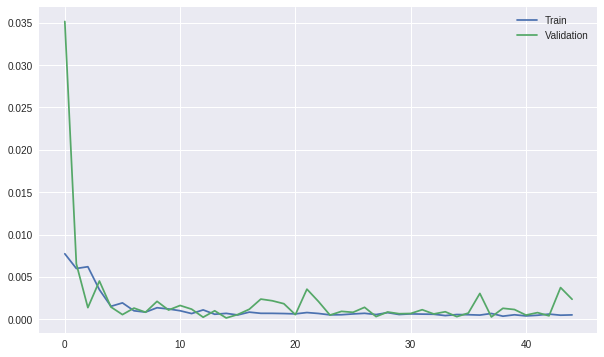

In [0]:
#plotting the loss and validation loss
plt.figure(figsize=(10,6))

#get losses from the history saved
#### Karen: I added /4 here, because I think we should compare the relative loss with data size, validation is 4 times
plt.plot(np.array(history.history['loss'])/4, label='Train')  
plt.plot(history.history['val_loss'], label='Validation') 

plt.legend()  
plt.show()

In [0]:
x, y = test_gen[0]

#load best saved model
model = load_model('model.h5')

#make predictions
pred = model.predict(x)

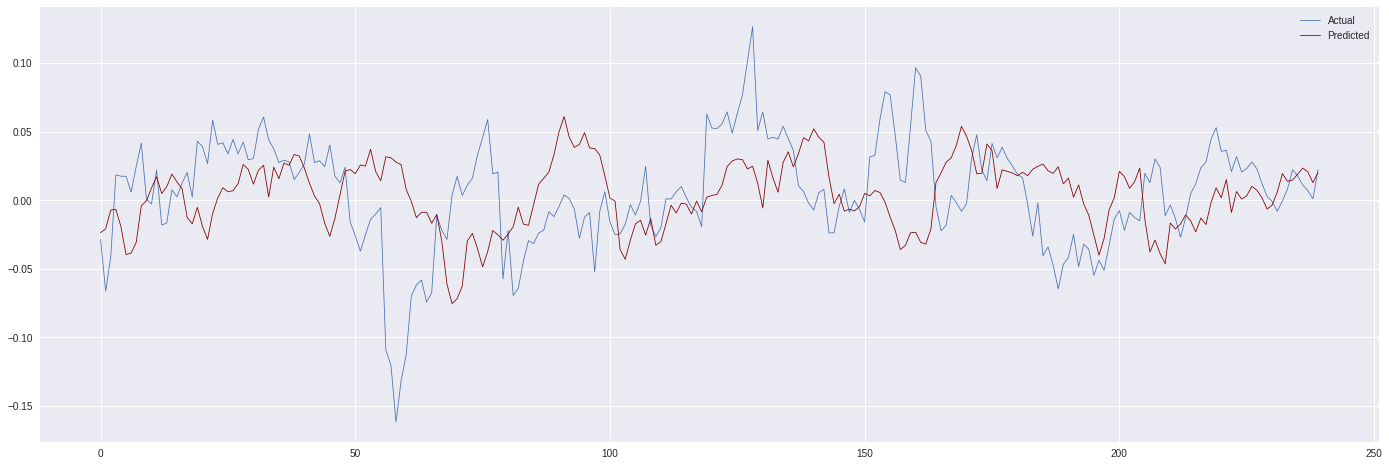

In [0]:
#plot them
plt.figure(figsize=(24,8))

#get length of the results
cycles = np.arange(len(y))

#plot cycles agaonts real
plt.plot(cycles, y, label="Actual", lw=0.8)

#plot cycles against predictions made
plt.plot(cycles, pred, 'maroon', label="Predicted", lw=0.8)

plt.legend()
plt.show()

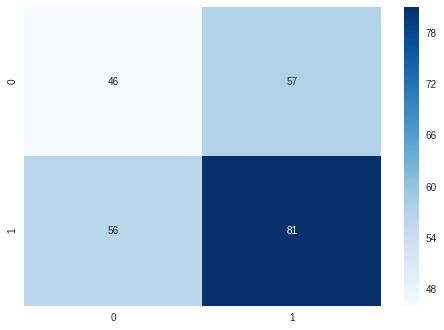

In [0]:
pred_binary = np.where(pred.ravel()>0, 1, 0)
y_binary = np.where(y>0, 1, 0)

cm = confusion_matrix(y_binary, pred_binary)
sns.heatmap(cm, annot=True, cmap='Blues')

In [0]:
print(classification_report(y_binary, pred_binary))

print ('Accuracy: %s' % (accuracy_score(y_binary, pred_binary)*100))

              precision    recall  f1-score   support

           0       0.45      0.45      0.45       103
           1       0.59      0.59      0.59       137

    accuracy                           0.53       240
   macro avg       0.52      0.52      0.52       240
weighted avg       0.53      0.53      0.53       240

Accuracy: 52.916666666666664


In [0]:
#ROC curve

fpr, tpr, thresholds = metrics.roc_curve(y_binary, pred_binary)
roc_auc = metrics.auc(fpr, tpr)

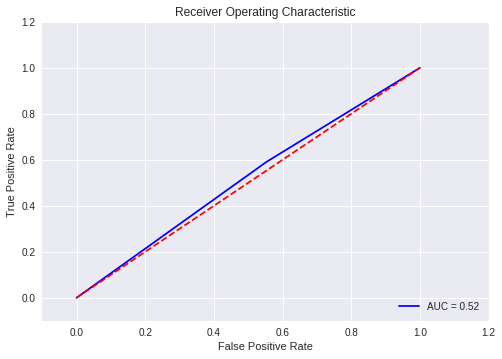

In [0]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [0]:
metrics.mean_absolute_error(y, pred)